##  Project: Finding Donors for *CharityML*

This project employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. The best candidate algorithm from preliminary results is chosen and further optimized to best model the data. 

The goal with this implementation is to construct a model that accurately **predicts whether an individual makes more than $50,000.** 

This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). Dataset are pre-processed (e.g. `'fnlwgt'` feature and records with missing or ill-formatted entries removed).

## Imports

In [35]:
# core
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# graphings
import visuals as vs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Exploring the Data

In [36]:
data = pd.read_csv("census.csv")
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset to determine how many individuals fit into either group and percentage of these individuals making more than \$50,000.

- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.Z

In [37]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data.income[data['income'] == '>50K'].count()

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.income[data.income == '<=50K'].count()

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Data Preparation

### Transforming Skewed Continuous Features

- A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  


- Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized.

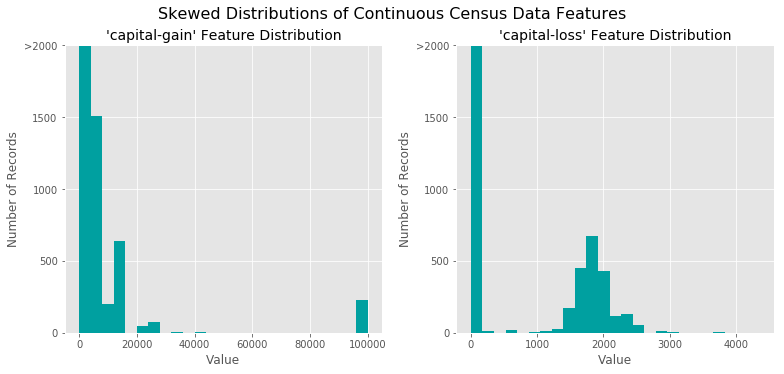

In [38]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

- For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. 


- Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully. 

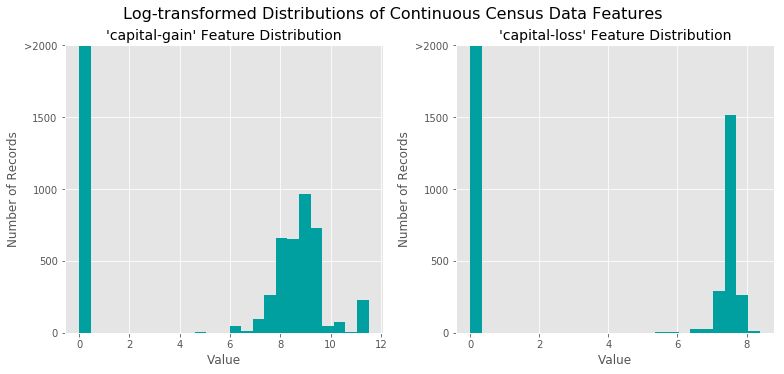

In [39]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
- In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. 


- Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. However, once scaling is applied, observing the data in its raw form will no longer have the same original meaning.

In [40]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

C:\Users\ternp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

- From the table in **Exploring the Data** above, there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. 


- Additionally, as with the non-numeric features, non-numeric target label, `'income'`, needs to be converted to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), it can simply be encoded into two categories:`0` and `1`, respectively. 

In [41]:
# One-hot encode the 'features_log_minmax_transform'
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.astype('category').cat.codes

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)

print("{} total features after one-hot encoding.".format(len(encoded)))
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data

- All _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. 


- The data (both features and their labels) is split into training and test sets, with 80% of the data will be used for training and 20% for testing.

In [42]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=income)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. 

It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. 

We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. 

It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. 

We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. 

These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace

- If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?

In [43]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall
TOTAL = len(income)

TP = np.sum(income)
FP = TOTAL - TP

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = TP / TOTAL
recall = TP / (TP + FN)
precision = TP / (TP + FP)

print("Accuracy: {}, Recall: {}, Precision: {}".format(accuracy, recall, precision))

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Accuracy: 0.2478439697492371, Recall: 1.0, Precision: 0.2478439697492371
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

The 3 initial models chosen for this dataset are KNN, Logistic Regression, and Random Forest. These models are chosen as they have wide differences in their characteristics.

    
- Strengths of models:


    1. KNN: KNN is considered a simple model as it involves just matching a particular data point to other nearest data points around it. Therefore, the model's explanability is high (i.e. it is easy to understand how the model derive its decision).
    
    2. Logistic Regression: Logistic Regression is fast and computationally cheap to implement. Furthermore, feature importance could be done by identifying variable with high coefficicent.
    
    3. Random Forest Classification: It is an ensemble of decision trees with bagging. The higher complexity of this model should technically lead to better performance compared to KNN and Logistic Regression. 
    
  
- Weaknesses of models:


    1. KNN: KNN is memory intensive and do not provide importance or coefficients of variables. Therefore, it won't be possible to do feature selection with KNN.
        
    2. Logistic Regression: Logistic Regression will not be able to perform if the interactions between features do not exhibits strong linear relationship. 
    
    3. Random Forest Classification: Random Forest is considered a complex model as it involves bagging and ensembling the results of multiple decision trees. Therefore, the model's explainability is lower (i.e. harder to understand how the model derived its prediction).
    
    
- What makes this model a good candidate:


    1. KNN: It can be used to solve classification problem and the model is easy to understand.
    
    2. Logistic Regression: It can be used to solve classification problem and it is computationally cheap to implement.
    
    3. Random Forest Classification: It can be used to solve classification problem, able to model non-linearity, and might give better performance given the ensemble of decision trees with bagging used.

### Implementation - Creating a Training and Predicting Pipeline

In [44]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    Training and predicting pipeline to evaluate performance of models
    
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # get start time
    start = time()
    
    # Get the predictions on the test set, then get predictions on the first 300 training samples
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    
    # get end time
    end = time()
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


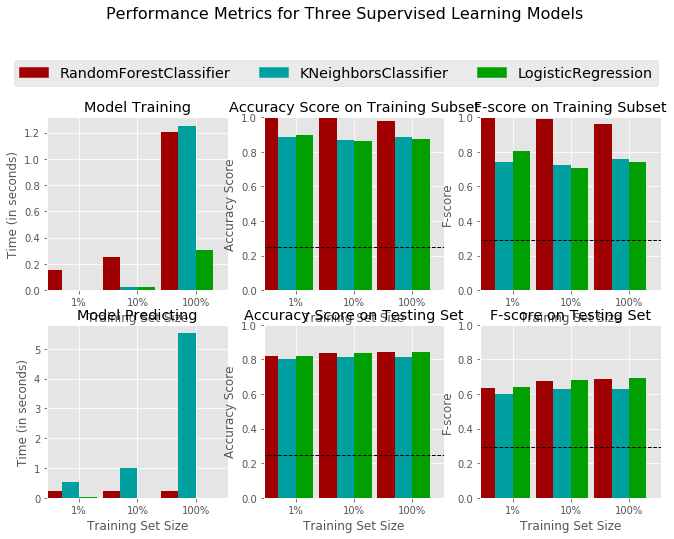

In [45]:
# Initialize the three models
clf_A = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf_B = KNeighborsClassifier(n_jobs=-1)
clf_C= LogisticRegression(random_state=0, solver='liblinear')

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = len(y_train) // 10
samples_1 = len(y_train) // 100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [46]:
# perform cross-validation accuracy scoring
rf_cv_accuracy = cross_val_score(clf_A, X_train, y_train, cv=5, n_jobs=-1)
lg_cv_accuracy= cross_val_score(clf_C, X_train, y_train, cv=5, n_jobs=-1)

print("Accuracy: %0.3f (+/- %0.3f)" % (rf_cv_accuracy.mean(), rf_cv_accuracy.std() * 2))
print("Accuracy: %0.3f (+/- %0.3f)" % (lg_cv_accuracy.mean(), lg_cv_accuracy.std() * 2))

# perform cross-validation with f1 scoring
scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')
rf_cv_f1 = cross_val_score(clf_A, X_train, y_train, cv=5, n_jobs=-1, scoring = scorer)
lg_cv_f1= cross_val_score(clf_C, X_train, y_train, cv=5, n_jobs=-1, scoring = scorer)

print("F1 Score: %0.3f (+/- %0.3f)" % (rf_cv_f1.mean(), rf_cv_f1.std() * 2))
print("F1 Score: %0.3f (+/- %0.3f)" % (lg_cv_f1.mean(), lg_cv_f1.std() * 2))

Accuracy: 0.842 (+/- 0.010)
Accuracy: 0.841 (+/- 0.004)
F1 Score: 0.837 (+/- 0.010)
F1 Score: 0.835 (+/- 0.005)


----
## Improving Results

### Choosing the Best Model

- The best model for this specific problem is LogisticRegression. 


- LogisticsRegression trained the fastest and has the highest cross-validation score on accuracy and F1 score. Furthermore, it also has the best performance on the test set.


- It seems the data has linear relationship given that a simple LogisticRegression is able to outperform RandomForestClassifier, which is an ensemble classification method. 

### Describing the Model in Layman's Terms

- Logistic Regression models the relationship betwen one dependent variable and other independent variables.


- Logistic Regression makes use of regression analysis to find the coefficient of each features. Essentially, it calculates how much weightage or consideration should be given to each feature: less important features will have a lower coefficient, while more important features will have higher coefficient. 


- The sign of the coefficient (e.g. positive or negative) determines how the variable contribute to the prediction. For instance, a variable with high negative coefficient means the presence of this variable will drive the prediction towards one class of prediction.

### Implementation: Model Tuning

In [47]:
# Initialize the classifier
clf = LogisticRegression(solver = 'liblinear', random_state=0)

# Create the parameters list for tuning
parameters = {'penalty': ['l1', 'l2'], 'max_iter': range(80, 120, 2), 'C' : np.arange(0.5, 1.5, 0.25)}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = RandomizedSearchCV(clf, parameters, scoring=scorer, n_jobs=-1, cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)
   
# Get best parameters
print(grid_fit.best_params_)
    
# Get the estimator
best_clf = grid_fit.best_estimator_
    
# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\ternp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'penalty': 'l2', 'max_iter': 106, 'C': 0.75}


C:\Users\ternp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8418
F-score on testing data: 0.6912

Optimized Model
------
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6919


### Final Model Evaluation

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.8418     |   0.8420        |
| F-score        |        0.6912     |   0.6919        |


- The optimised Logistic Regression model performed slightly better than unoptimised Logistic Regression model, with accuracy improving by 0.002 and F-score improving by 0.0007.


- Compared to naive prediction benchmarks, the accuracy and F-score of optimised Logistic Regression improved by 0.5942 and 0.4  respectively.

----
## Feature Importance

- An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. 


- By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. 

### Implementation - Extracting Feature Importance

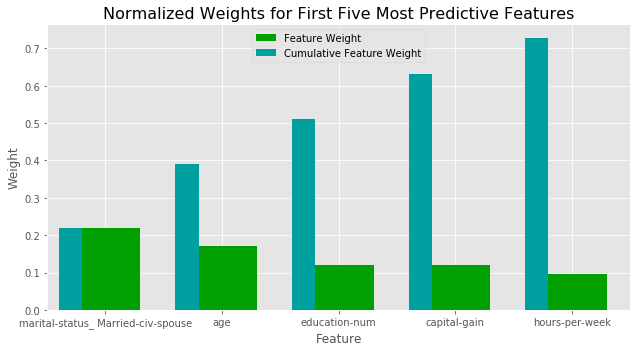

In [48]:
# Train the supervised model on the training set
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)

# Extract the feature importance
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

###  Extracting Feature Importance

- The top 5 features identified are `maritial_status`, `age`, `education_num`, `capital_gain`, and `hours_per_week`. Out of the 5 initial features guessed, the two differences are `maritial_status` and `hours_per_week`.


- The `maritial_status` could possibly indicate whether someone has the emotional maturity to settle down and thus imply whether the individual will be self-motivated to strive for higher income. This could also simply means that only people who are earning above $50K are interested to get married.


- The `hours_per_week` feature indicate how much someone has worked in a week; it makes sense that it is an important feature as even though an individual might be working in a low hourly-wage occupation, the individual would have earned substantial amount of he or she puts in the hours.

### Feature Selection
- With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. 


- From the visualization above, the top five most important features contribute more than half of the importance of **all** features present in the data. This implies that it is possible to *reduce the feature space* and simplify the information required for the model to learn. 


- The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [49]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6919

Final Model trained on reduced data
------
Accuracy on testing data: 0.8304
F-score on testing data: 0.6656


C:\Users\ternp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


###  Effects of Feature Selection

- The accuracy and f-score dropped by 0.0145 and 0.0359 respectively when only the top 5 features are considered.


- If training time was a factor and the dataset is much larger, I would consider using the reduced data as my training set since the time and money (computational power) saved could well justify the slight decrease in model's performance. 


- Using less features will also help in improving model's explanability to stakeholders.